In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import time
import pandas as pd
import umap
from NEExT import NEExT
import igraph as ig
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc 
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import seaborn as sns
from collections import Counter 


In [2]:
#datapath = '/Users/francois/Book/GraphMiningNotebooks/Datasets/NCI/'
datapath = '../Datasets/NCI/'

In [3]:
## nci1 or nci109
dataset = 'nci1'

## csv data files
edges = datapath+dataset+'_edges.csv'
node_graph_mapping = datapath+dataset+'_graph_indicator.csv'
graph_labels = datapath+dataset+'_graph_labels.csv'
node_labels = datapath+dataset+'_node_labels.csv'

# Initialize NEExT and set logging level
nxt = NEExT(log_level="ERROR")

# Load data with node reindexing and largest component filtering
# Load as networkx for now
print("\nLoading data...")
graph_collection = nxt.read_from_csv(
    edges_path=edges,
    node_graph_mapping_path=node_graph_mapping,
    graph_label_path=graph_labels,
    node_features_path=node_labels,
    reindex_nodes=True,
    filter_largest_component=True,
    graph_type="networkx",
    node_sample_rate=1.0
)


2025-06-04 17:09:07,132 - NEExT - INFO - NEExT framework initialized
2025-06-04 17:09:07,132 - NEExT - INFO - Reading graph data from CSV files



Loading data...


2025-06-04 17:09:40,462 - NEExT - INFO - Successfully loaded graph collection


# EDA

In [4]:
## number of graphs
n_graphs = graph_collection.describe()['num_graphs']
n_graphs

4110

In [5]:
## graph labels
g_labels = graph_collection.get_labels()['label']

## number of vertices and edges
g = ig.Graph()
for i in range(n_graphs):
    g[i] = ig.Graph.from_networkx(graph_collection.graphs[i].G, vertex_attr_hashable='name').simplify()
    g[i].vs['label'] = [int(l) for l in g[i].vs['node_label']] ## map node labels to integers
vc = [g[i].vcount() for i in range(n_graphs)]
ec = [g[i].ecount() for i in range(n_graphs)]


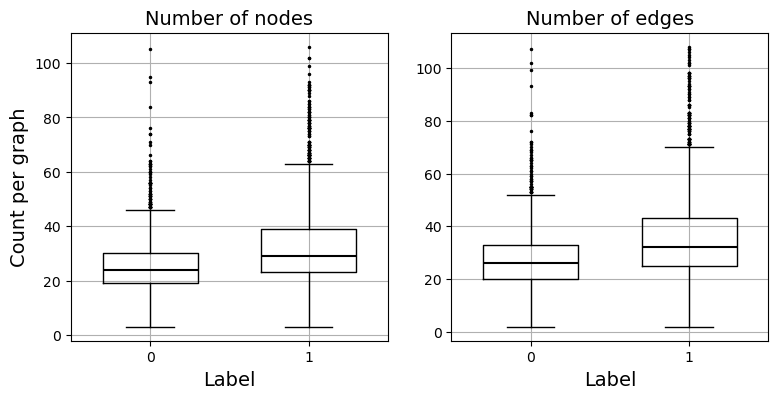

In [6]:
## Plot number of nodes/edges for graphs with label 0 and 1 resp.
a = [vc[i] for i in range(len(vc)) if g_labels[i]==0]
b = [vc[i] for i in range(len(vc)) if g_labels[i]==1]
c = [ec[i] for i in range(len(ec)) if g_labels[i]==0]
d = [ec[i] for i in range(len(ec)) if g_labels[i]==1]

plt.subplots(1,2,figsize=(9,4))
plt.subplot(121)
plt.boxplot([a,b],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
plt.ylabel('Count per graph',fontsize=14);
plt.xlabel('Label',fontsize=14)
plt.grid()
plt.title('Number of nodes',fontsize=14);

plt.subplot(122)
plt.boxplot([c,d],labels=['0','1'],widths=.6, 
            flierprops = dict(marker='.', markerfacecolor='black', markersize=3,linestyle='none'),
            medianprops = dict(linestyle='-', linewidth=1.5, color='black'))
#plt.ylabel('Count per graph',fontsize=11)
plt.xlabel('Label',fontsize=14);
plt.grid()
plt.title('Number of edges',fontsize=14);
#plt.savefig('nci_counts.eps');


graph label: 0


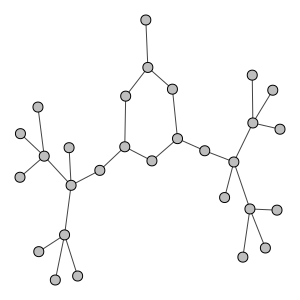

In [7]:
## example of a graph with label 0
id = 799
print('graph label:',g_labels[id])
ig.plot(g[id], bbox=(0,0,300,300), vertex_size=10, vertex_color='grey', 
        vertex_label=g[id].vs['node_label'],vertex_label_size=0)
#ig.plot(sg,target='nci_0.eps',bbox=(0,0,300,300))


label: 1


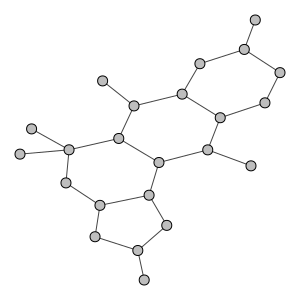

In [8]:
## example of a graph with label 1 
id = 2299
print('label:',g_labels[id])
ig.plot(g[id], bbox=(0,0,300,300), vertex_size=10, vertex_color='grey', 
        vertex_label=g[id].vs['node_label'],vertex_label_size=0)
#ig.plot(sg,target='nci_1.eps',bbox=(0,0,300,300))


## NEExT features


In [9]:
%%time
nxt.set_log_level("ERROR")

# Compute node features
features = nxt.compute_node_features(
    graph_collection=graph_collection,
    feature_list=["all"],
    feature_vector_length=5,
    show_progress=True
)


Computing node features:   0%|          | 0/4110 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 1.5 s, total: 1min 10s
Wall time: 1min 10s


In [10]:
features.normalize()
features.features_df.head()

,node_id,graph_id,page_rank_0,page_rank_1,page_rank_2,page_rank_3,page_rank_4,degree_centrality_0,degree_centrality_1,degree_centrality_2,...,load_centrality_0,load_centrality_1,load_centrality_2,load_centrality_3,load_centrality_4,basic_expansion_0,basic_expansion_1,basic_expansion_2,basic_expansion_3,basic_expansion_4
0,0,0,-0.358277,1.639054,0.498855,0.995242,0.972477,-0.607447,1.314921,0.350025,...,-1.001213,-0.050409,0.062723,1.650805,0.770722,-1.424567,1.29963,-0.168183,1.345537,0.082086
1,1,0,-0.358277,1.639054,0.498855,0.995242,0.972477,-0.607447,1.314921,0.350025,...,-1.001213,-0.050409,0.062723,1.650805,0.770722,-1.424567,1.29963,-0.168183,1.345537,0.082086
2,2,0,-0.348647,1.671677,0.537920,0.456502,1.138563,-0.607447,1.314921,0.350025,...,-1.001213,-0.050409,-0.661880,-0.567145,0.594437,-1.424567,1.29963,-0.168183,0.108746,0.082086
3,3,0,-0.348647,1.671677,0.537920,0.456502,1.138563,-0.607447,1.314921,0.350025,...,-1.001213,-0.050409,-0.661880,-0.567145,0.594437,-1.424567,1.29963,-0.168183,0.108746,0.082086
4,4,0,-0.272766,1.928719,0.139982,0.697956,2.120017,-0.607447,1.314921,-0.252369,...,-1.001213,-0.050409,-0.755810,1.226382,1.986728,-1.424567,1.29963,-1.357380,0.108746,2.286707


In [11]:
%%time
# Compute graph embeddings
embeddings = nxt.compute_graph_embeddings(
    graph_collection=graph_collection,
    features=features,
    embedding_algorithm="approx_wasserstein",
    #embedding_dimension=16,
    embedding_dimension=len(features.feature_columns),
    random_state=42
)


CPU times: user 1.15 s, sys: 121 ms, total: 1.27 s
Wall time: 747 ms


In [12]:
# Use UMAP to reduce the embeddings to 2D for visualization
print("\nReducing embeddings to 2D using UMAP...")
# Extract embeddings as numpy array for UMAP
embedding_data = embeddings.embeddings_df[embeddings.embedding_columns].values

# Create and fit UMAP model
umap_model = umap.UMAP(n_neighbors=15, 
                      min_dist=0.1, 
                      n_components=2, 
                      random_state=42,
                      n_jobs=1)
embedding_2d = umap_model.fit_transform(embedding_data)

# Create a DataFrame with the 2D embeddings and labels
viz_df = pd.DataFrame({
    'UMAP1': embedding_2d[:, 0],
    'UMAP2': embedding_2d[:, 1],
    'graph_id': embeddings.embeddings_df['graph_id']
})

# Add class labels from graph collection
graph_labels_dict = {g.graph_id: g.graph_label for g in graph_collection.graphs}
viz_df['label'] = viz_df['graph_id'].map(graph_labels_dict)



Reducing embeddings to 2D using UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


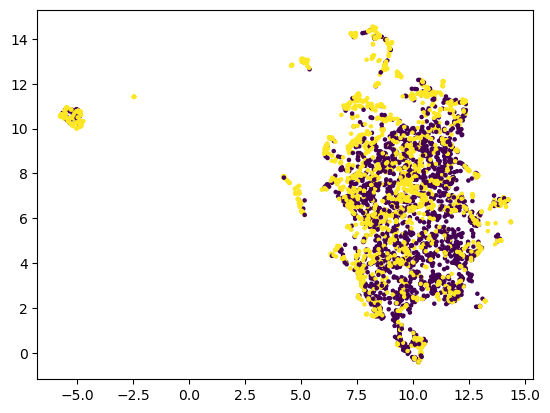

In [13]:
plt.scatter(viz_df.UMAP1, viz_df.UMAP2, c=viz_df.label, cmap='viridis',s=5);


In [14]:
## Classification with RF: node feature based embeddings only
D = embeddings.embeddings_df
D = np.array(D.drop(columns=['graph_id']))
RS = 42
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(D, g_labels, test_size=0.2, random_state=RS)
## random forest classifier -- accuracy
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7992700729927007


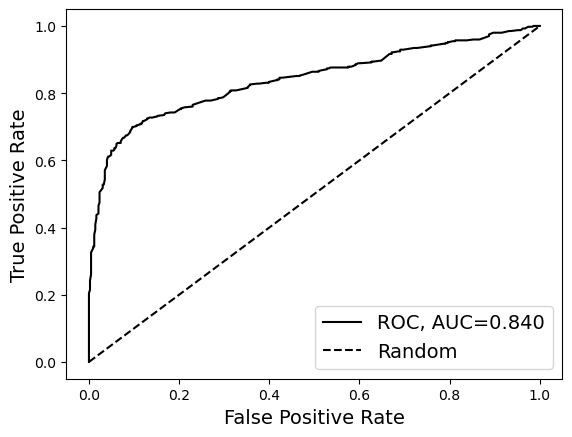

In [15]:
## ROC curve
y_probs = rfc_mdl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)
plt.plot(fpr,tpr,label="ROC, AUC="+str('%.3f' % auc),color='black')
plt.plot([0,1],[0,1],'--',label='Random',color='black')
plt.legend(loc=4,fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14);
#plt.savefig('nci_64d_roc.eps');


In [16]:
### Build graph-based features for each compound (graph)

def degrees(sg,md):
    ctr = Counter(sg.degree())
    return [ctr[i]/sg.vcount() for i in range(1,md+1)]

def core(sg,mc):
    ctr = Counter(sg.coreness())
    return [ctr[i] for i in range(1,mc+1)]


In [17]:
## Compute features for each graph
L = []
md = np.max([np.max(g[i].degree()) for i in range(n_graphs)])
mc = np.max([np.max(g[i].coreness()) for i in range(n_graphs)])
#ml = np.max([np.max(g[i].vs['label']) for i in range(ng)])

for i in range(n_graphs):
    sg = g[i]
    ## node and edge counts, density
    x = [sg.vcount(),sg.ecount(),sg.ecount()/sg.vcount()]
    ## assortativity
    a = sg.assortativity_degree()
    if np.isnan(a):
        a=0
    x.extend([a])
    ## degree distribution
    x.extend(degrees(sg,md))
    ## coreness distribution
    x.extend([i/sg.vcount() for i in core(sg,mc)])
    ## node labels distribution
    #x.extend(labels(sg,ml))
    L.append(x)

In [18]:
## store all features in a dataframe
col = ['nodes','edges','density','assort']
col.extend(['deg'+str(i) for i in np.arange(1,md+1)])
col.extend(['core'+str(i) for i in np.arange(1,mc+1)])
#col.extend(['label'+str(i+1) for i in np.arange(ml)])
F = pd.DataFrame(L,columns=col)
F.head()

,nodes,edges,density,assort,deg1,deg2,deg3,deg4,core1,core2,core3
0,21,21,1.000000,-0.542857,0.333333,0.333333,0.333333,0.000000,0.714286,0.285714,0.0
1,24,26,1.083333,-0.083333,0.166667,0.500000,0.333333,0.000000,0.250000,0.750000,0.0
2,29,29,1.000000,-0.440397,0.413793,0.275862,0.206897,0.103448,0.793103,0.206897,0.0
3,28,31,1.107143,-0.212291,0.142857,0.500000,0.357143,0.000000,0.214286,0.785714,0.0
4,23,23,1.000000,-0.286184,0.347826,0.304348,0.347826,0.000000,0.739130,0.260870,0.0


In [19]:
## EDA of the graphs
print(F.shape[0],'graphs')
print('avg nodes:',np.mean(F['nodes']))
print('avg edges:',np.mean(F['edges']))


4110 graphs
avg nodes: 29.03771289537713
avg edges: 31.611922141119223


In [20]:
D = embeddings.embeddings_df
D = np.array(D.drop(columns=['graph_id']))
g2v = datapath+dataset+'_g2v.csv'
_D = pd.read_csv(g2v, header=None)
_D = np.array(_D.drop(columns=[0]))
D = np.concatenate((D,_D,np.array(F)), axis=1)
D.shape


(4110, 125)

In [21]:
## three sets
RS = 42
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(D, g_labels, test_size=0.2, random_state=RS)
## random forest classifier -- accuracy
rfc_mdl = rfc(n_estimators=100, criterion='entropy')
rfc_mdl.fit(X_train,y_train)
y_pred = rfc_mdl.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8260340632603407


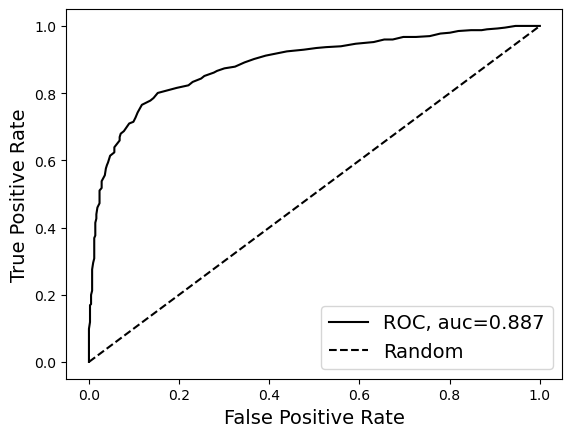

In [22]:
## ROC curve
y_probs = rfc_mdl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probs)
auc = metrics.roc_auc_score(y_test, y_probs)
plt.plot(fpr,tpr,label="ROC, auc="+str('%.3f' % auc),color='black')
plt.plot([0,1],[0,1],'--',label='Random',color='black')
plt.legend(loc=4,fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14);
#plt.savefig('nci_64d_roc.eps');


In [23]:
## bootstrap confidence interval for the AUC
def bootstrap(y_test,y_probs,n_boot=1000):
    y_pred = np.array(y_probs)
    y_true = np.array(y_test)
    scores = []
    rng = np.random.RandomState(RS)
    for i in range(n_boot):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        sc = metrics.roc_auc_score(y_true[indices], y_pred[indices])
        scores.append(sc)
    sorted_scores = np.array(scores)
    sorted_scores.sort()
    conf_lo = sorted_scores[int(0.05 * len(sorted_scores))]
    conf_up = sorted_scores[int(0.95 * len(sorted_scores))]
    return (conf_lo, conf_up)
bootstrap(y_test,y_probs)

(0.8663209364350274, 0.9064869719336017)

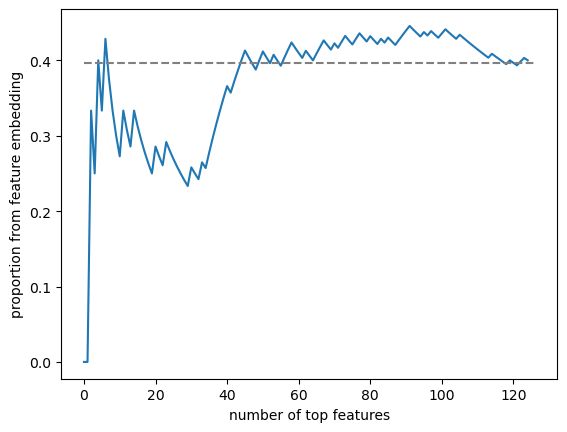

In [24]:
## top features - how many from features or g2v?
## first 50 are from node features embedding, next 64 from g2v last 12 from graph features
l = D.shape[1]
x = np.argsort(rfc_mdl.feature_importances_)
top = [x[i] for i in np.arange(len(x)-1,-1,-1)] ## reverse order
n_features = np.cumsum(np.array(top) < 50)
n_total = np.arange(1,l+1)
plt.plot(n_features/n_total)
plt.hlines(50/(l+1),0,l+1,linestyles='dashed',color='grey')
plt.xlabel('number of top features')
plt.ylabel('proportion from feature embedding');


# Unsupervised

We perform simple k-means clustering (fixing k to 10) and explore the content of the different clusters.

We plot the proportion of graphs with label == 1 vs the size of the cluster.

We see several small clusters with a large proportion of graphs with label == 1.



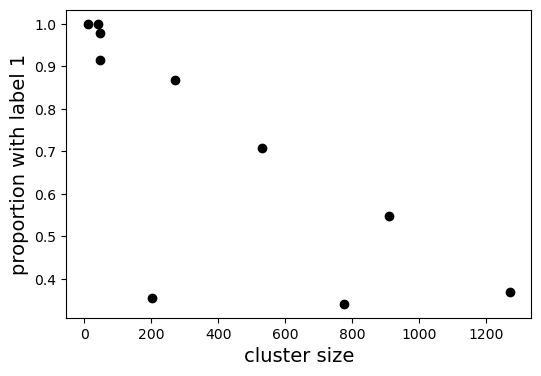

In [25]:
_D = (D - D.mean(axis=0)) / (D.std(axis=0))
NCL = 10 ## number of clusters
cl = KMeans(n_clusters=NCL, n_init=10).fit(_D).labels_
K = pd.DataFrame(np.array([g_labels,cl,np.repeat(1,len(g_labels))]).transpose(),columns=['label=1','cluster','total'])
C = K.groupby(by='cluster').sum()
C['ratio'] = C['label=1']/C['total']
plt.figure(figsize=(6,4))
plt.plot(C['total'],C['ratio'],'o',color='black')
plt.xlabel('cluster size', fontsize=14)
plt.ylabel('proportion with label 1', fontsize=14);
#plt.savefig('kmeans_1.eps');

In [26]:
## same data in a table
_df = C.sort_values(by='ratio',ascending=False).round(decimals=3)
_df


,label=1,total,ratio
cluster,,,
4,41,41,1.000
6,10,10,1.000
7,47,48,0.979
5,43,47,0.915
3,234,270,0.867
8,376,532,0.707
0,500,911,0.549
1,469,1272,0.369
2,72,203,0.355


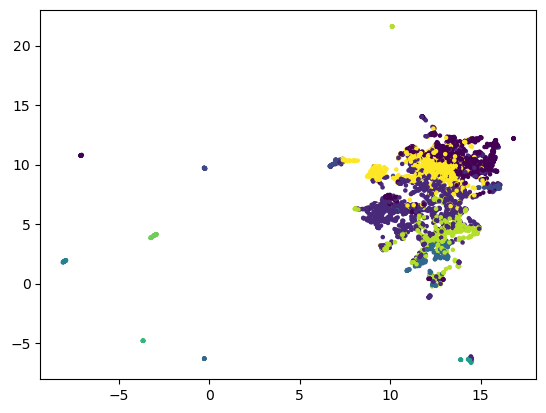

In [27]:
Um = umap.UMAP(metric='cosine').fit(_D)
plt.scatter(Um.embedding_[:,0],Um.embedding_[:,1],c=cl,cmap='viridis',s=5);


In [28]:
## we typically find a small 'pure' cluster of size 10
## look at this small cluster:
CL = _df.index[_df.total==10][0]
_df = F.loc[[i for i in range(len(cl)) if cl[i]==CL]]
_df


,nodes,edges,density,assort,deg1,deg2,deg3,deg4,core1,core2,core3
2077,82,97,1.182927,-0.465995,0.121951,0.439024,0.390244,0.048780,0.158537,0.841463,0.0
2078,88,103,1.170455,-0.494124,0.136364,0.431818,0.386364,0.045455,0.215909,0.784091,0.0
2079,78,93,1.192308,-0.513733,0.102564,0.448718,0.410256,0.038462,0.115385,0.884615,0.0
2080,82,96,1.170732,-0.467626,0.134146,0.426829,0.402439,0.036585,0.195122,0.804878,0.0
2081,86,101,1.174419,-0.535722,0.127907,0.430233,0.406977,0.034884,0.197674,0.802326,0.0
2082,78,93,1.192308,-0.513733,0.102564,0.448718,0.410256,0.038462,0.115385,0.884615,0.0
3833,80,94,1.175000,-0.494897,0.125000,0.437500,0.400000,0.037500,0.175000,0.825000,0.0
3842,79,93,1.177215,-0.506528,0.126582,0.430380,0.405063,0.037975,0.177215,0.822785,0.0
3843,80,95,1.187500,-0.506849,0.112500,0.437500,0.412500,0.037500,0.137500,0.862500,0.0
3989,90,105,1.166667,-0.477663,0.144444,0.433333,0.366667,0.055556,0.233333,0.766667,0.0


In [29]:
_df.mean()

nodes      82.300000
edges      97.000000
density     1.178953
assort     -0.497687
deg1        0.123402
deg2        0.436405
deg3        0.399077
deg4        0.041116
core1       0.172106
core2       0.827894
core3       0.000000
dtype: float64

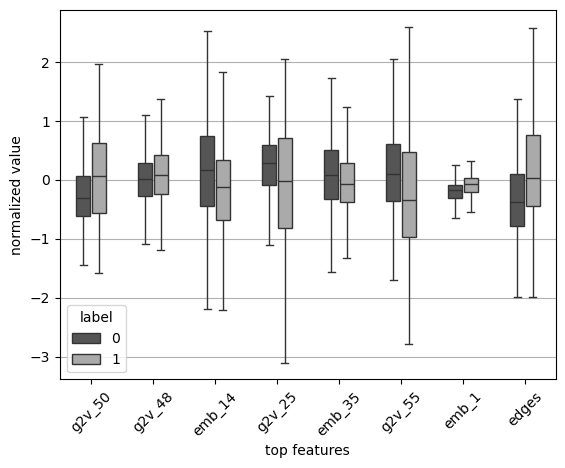

In [36]:
n_top = 8
_D = (D - D.mean(axis=0)) / (D.std(axis=0))

data = {
    'feature' : np.concatenate([np.repeat(str(t+1),n_graphs) for t in top[:n_top]]),
    'value' : np.concatenate([np.array(_D[:,t]) for t in top[:n_top]]),
    'label' : list(g_labels)*n_top
}
_df = pd.DataFrame(data)
sns.boxplot(x='feature', y='value', data=_df, hue='label', palette='grey', showfliers=False, width=.5, gap=.1);
plt.xlabel('top features')
plt.ylabel('normalized value')
plt.grid(axis='y')
f = ['emb_'+str(i) for i in np.arange(0,50)] + ['g2v_'+str(i) for i in np.arange(0,64)] + list(F.columns)
plt.xticks(np.arange(n_top), [f[top[i]] for i in range(n_top)], rotation=45);


In [37]:
## 50 from feature-based embedding
## 64 from g2v
## 11 graph features

n_top = 50
print('top',n_top,'features:')
print('feature-based embedding:',len([f[i] for i in top[:n_top] if i<50]))
print('graph2vec:',len([f[i] for i in top[:n_top] if i>=50 and i<114]))
print('graph features:',[f[i] for i in top[:n_top] if i>=114])


top 50 features:
feature-based embedding: 20
graph2vec: 28
graph features: ['edges', 'nodes']
